### Preambule

This notebook allows you to retrieve computational performance of your analysis

Before using the code below you first have to create the file `log_job.csv` in your datahome. To do so open a terminal outside your jupyterhub session and run the following command in a terminal after ssh on datarmor (``$ ssh dcazau@datarmor.ifremer.fr ``) :

``$ pbs-report -u dcazau -b 20220616 | awk '$2~/dcazau/{print $1 "," $2 "," $3 "," $4 "," $5 "," $6 "," $7 "," $8 "," $9 "," $10 "," $11 "," $12 "," $13 "," $14 "," $15 "," $16 "," $12/$13}' > log_job.csv ``


### Note

Only analysis from the notebook 'datasetScale.ipynb' are taken into account for the moment

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import ast
import matplotlib.pyplot as plt

all_files = glob.glob("log_job.csv")
meta_job =  pd.read_csv(all_files[0], header=None)

path_osmose_home = "/home/datawork-osmose/"
path_log = os.path.join(path_osmose_home, 'log')

all_jobID = glob.glob(os.path.join(path_log,'jobID_*'))

In [14]:
ind_pbsreport_jobID = 0
ind_pbsreport_userID = 1
ind_pbsreport_timestampJobCreation = [4,5]

ind_pbsreport_executionHost = 7
ind_pbsreport_node = 8

ind_pbsreport_coreMEMORY = 9
ind_pbsreport_virtualMEMORY = 10

ind_pbsreport_usedCPUtime = 11
ind_pbsreport_usedWallTime= 12

ind_pbsreport_queueWaitTime= 13
ind_pbsreport_suspendTime= 14
ind_pbsreport_exit= 15

ind_pbsreport_avCPU= 16

def formatALL(all_jobID , in_ID):
    
    # filter only rows of all_jobID (ie your datawork-osmose/log) for the current analysis module (eg resample)
    out_all = pd.concat( [ pd.read_csv(f, header=0,usecols=['analID','jobID_'+in_ID]) for f in all_jobID ] )

    out_all.reset_index(inplace=True, drop=True)
        
    out_all['dataset_ID']=str(np.ones((len(out_all),1)))
    out_all['analysis_fs']=np.ones((len(out_all),1))
    out_all['dataset_Volume']=np.ones((len(out_all),1))
    out_all['dataset_totalDurationMins']=np.ones((len(out_all),1))
    out_all['total_nber_audio_files']=np.ones((len(out_all),1))

    out_all['usedWallTime']=np.zeros((len(out_all),1))
    out_all['avCPU']=np.ones((len(out_all),1))
    out_all['avMEM']=np.ones((len(out_all),1))
    out_all['timestampJobCreation']=np.ones((len(out_all),1))    

    for index, row in out_all.iterrows():
        
        ll=row['analID']
        if ll < 10:
            analID = '0000' + str(ll)
        elif ll < 100:
            analID = '000' + str(ll)
        elif ll < 1000:
            analID = '00' + str(ll)
        elif ll < 10000:
            analID = '0' + str(ll)
        else:
            analID = str(ll)    
            
        # join with analysis params
        current_anal = pd.read_csv(os.path.join(path_log,'analysis_fiche_'+analID+'.csv') , header=0)
        out_all.at[index,'dataset_ID'] = current_anal['dataset_ID'][0]        
        out_all.at[index,'analysis_fs'] = current_anal['analysis_fs'][0]       
        out_all.at[index,'dataset_Volume'] = int(current_anal['dataset_Volume'][0])      
        out_all.at[index,'dataset_totalDurationMins'] = current_anal['dataset_totalDurationMins'][0]        
        out_all.at[index,'total_nber_audio_files'] = current_anal['total_nber_audio_files'][0]        
                
        # join with pbs params
        list_job=ast.literal_eval(row['jobID_'+in_ID])# use literal_eval to convert the str 'row['jobID_'+in_ID]' into a list or list of lists
        
        usedWallTime = []
        avCPU=0
        avMEM=0   
        ct=0
                
        # here you can have several jobs in list_job when you use distributed calcul (eg for 'resample'), so you will average 
        # pbs infos over those jobs, except for the used wall time, you keep only the longest one
        for ii in list_job:

            if len(ii)==0:
                continue
            
            # find row in meta_job with current job
            ind_job = np.where(int(ii)==meta_job[ind_pbsreport_jobID])[0]
                        
            if len(ind_job)==0:
                continue
            
            # compute total usedWallTime with current job
            usedWallTime.append(meta_job.iloc[ind_job[0]][ind_pbsreport_usedWallTime])

            # compute averagedCPU with current job
            avCPU+=meta_job.iloc[ind_job[0]][ind_pbsreport_avCPU]

            # compute averaged used memory with current job
            avMEM+=int(meta_job.iloc[ind_job[0]][ind_pbsreport_coreMEMORY][:-2])


            ct+=1
            
        if len(ind_job)==0:
            continue
                
        if len(usedWallTime)>0:
            out_all.loc[index,'usedWallTime'] = round(np.max(np.array(usedWallTime))/60,1)  
            out_all.loc[index,'avCPU'] = avCPU/ct 
            out_all.loc[index,'avMEM'] = avMEM/ct
            out_all.loc[index,'timestampJobCreation'] = meta_job.iloc[ind_job[0]][ind_pbsreport_timestampJobCreation[0]]+'T'+meta_job.iloc[ind_job[0]][ind_pbsreport_timestampJobCreation[1]]
                
    return out_all

In [15]:
# how it works : 
#  - HERE we first loop over the different analysis modules (ie 'resample','computeFeaturesDatasetScale'...), the idea is to catch all jobs from the different modules
#  - THEN function formatALL : we then loop over the different jobs computed based on log data (ie '/home/datawork-osmose/log/*.csv'), keep only those performing the current module, and search for their pbs informations in log_job.csv, ie variable meta_job

path_osmose_home = "/home/datawork-osmose/"
path_log = os.path.join(path_osmose_home, 'log')

anal_block= ['resample','computeFeaturesDatasetScale','buildNewFeatures','reaggregateFeat']

out=pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
for aa in anal_block:    
    cur_out=formatALL(all_jobID , aa)
    out=pd.concat([out, cur_out],ignore_index=True)

# simply remove job where you do not have infos from log_job.csv, ie you have old jobs in your folder /log but not in log_job.csv
out=out[ out['usedWallTime'] >0]

#### Here are your summary data for computational performance , mixing information on the dataset (eg dataset_Volume), on the analysis type (eg jobID_resample) and on the computational resources (avCPU)

In [16]:
out

,analID,jobID_resample,dataset_ID,analysis_fs,dataset_Volume,dataset_totalDurationMins,total_nber_audio_files,usedWallTime,avCPU,avMEM,timestampJobCreation,jobID_computeFeaturesDatasetScale,jobID_buildNewFeatures,jobID_reaggregateFeat
0,1,"['698208', '698209', '698210', '698211']",SPMAuralA_2010,16000.0,156.0,39705.395508,1807.0,88.6,0.988851,2.306100e+04,2022/06/16T20:17,NaN,NaN,NaN
2,0,"['698164', '698165', '698166', '698167', '6981...",Hadocc,2456.0,39.0,10002.621384,8898.0,14.4,0.940310,2.288067e+04,2022/06/16T20:15,NaN,NaN,NaN
3,3,"['705479', '705480', '705481', '705482', '7054...",SPMAuralA_2011,12000.0,95.0,24324.470215,2214.0,55.4,0.983042,2.524240e+04,2022/06/17T09:34,NaN,NaN,NaN
4,1,NaN,SPMAuralA_2010,16000.0,156.0,39705.395508,1807.0,6.9,23.081900,4.510998e+07,2022/06/16T20:17,['698213'],NaN,NaN
6,0,NaN,Hadocc,2456.0,39.0,10002.621384,8898.0,3.7,23.062800,3.607583e+07,2022/06/16T20:15,['698183'],NaN,NaN
7,3,NaN,SPMAuralA_2011,12000.0,95.0,24324.470215,2214.0,5.0,20.294300,4.307482e+07,2022/06/17T09:34,['705485'],NaN,NaN
8,1,NaN,SPMAuralA_2010,16000.0,156.0,39705.395508,1807.0,4.9,0.650349,8.324673e+06,2022/06/16T20:17,NaN,"['698214', '698215', '698216', '698217', '6982...",NaN
10,0,NaN,Hadocc,2456.0,39.0,10002.621384,8898.0,5.3,0.677420,8.847276e+06,2022/06/16T20:15,NaN,"['698184', '698185', '698186', '698187', '6981...",NaN
11,3,NaN,SPMAuralA_2011,12000.0,95.0,24324.470215,2214.0,3.9,0.689238,6.443552e+06,2022/06/17T09:34,NaN,"['705486', '705487', '705488', '705489', '7054...",NaN
12,1,NaN,SPMAuralA_2010,16000.0,156.0,39705.395508,1807.0,4.4,0.965779,2.399016e+07,2022/06/16T20:17,NaN,NaN,['698222']


### By user scenario

In this code cell, it allows you to retrieve elapsed time for a given processing chain for your different dataset, ie it generates sentences such as 

"Dataset Hadocc  with a total volume of 39 (GB) takes 14.0 (mins)"

For example, the scenario of processing chains are defined using list like `matind_scenar_1`. In the example below, `matind_scenar_1=[1,2,3]` describes the chain `'computeFeaturesDatasetScale'>'buildNewFeatures'>'reaggregateFeat'`. Indexes `[1,2,3]` refer to the list of possible analysis `anal_block`

In [31]:
def mins_to_hour(valmins):
    if valmins > 60:
        return str(round(valmins,1)) + ' (h) '
    return str(round(valmins,0)) + ' (mins) '

def compute_cumul_wt(matval,matind):
    resmean=[]
    resstd=[]
    for ind in matind:
        resmean.append(np.mean(matval[ind]))
        resstd.append(np.std(matval[ind]))
    return resmean,resstd

matind_scenar_1=[1,2,3] # scenario 1 : build soundscape figures without resampling

list_scenar = [ matind_scenar_1 ]

for scenar in list_scenar:

    print('%%%%%%',scenar,'%%%%%% \n')
    
    for ddd in np.unique(out['dataset_ID']):

        list_block_anal = []
        for aa in anal_block: 
            list_block_anal.append(out[ (out['dataset_ID']==ddd) & (out['jobID_'+aa].notnull())]['usedWallTime'].values)

        x = compute_cumul_wt(list_block_anal,matind_scenar_1)
        
        dataset_totalVol = out[ (out['dataset_ID']==ddd) & (out['jobID_'+aa].notnull())]['dataset_Volume'].values[0]

        print('Dataset',ddd,' with a total volume of',int(dataset_totalVol),'(GB) takes',mins_to_hour(sum( compute_cumul_wt(list_block_anal,scenar)[0] )))
    
    print('\n ')    

%%%%%% [1, 2, 3] %%%%%% 

Dataset Hadocc  with a total volume of 39 (GB) takes 14.0 (mins) 
Dataset SPMAuralA_2010  with a total volume of 156 (GB) takes 16.0 (mins) 
Dataset SPMAuralA_2011  with a total volume of 95 (GB) takes 16.0 (mins) 

 


## Remaining codes are not commented, good luck!

### By analysis blocks

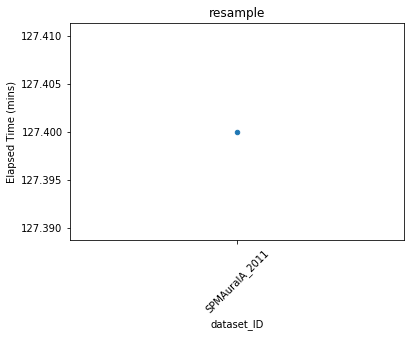

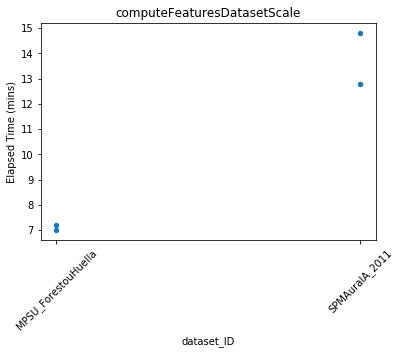

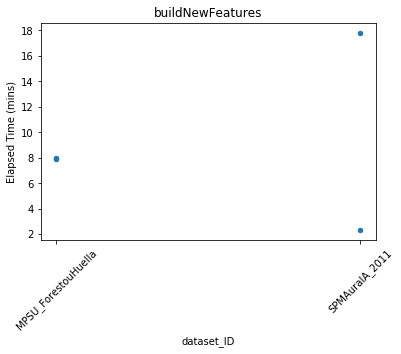

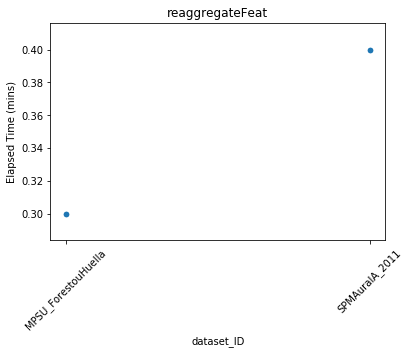

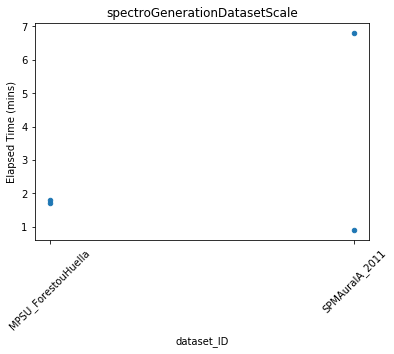

In [5]:
for aa in anal_block: 
    
    ax = out[out['jobID_'+aa].notnull()].plot.scatter(x='dataset_ID',y='usedWallTime')
    ax.set_ylabel('Elapsed Time (mins)')
#     ax.set_xlabel('Dataset volume (GB)')
    ax.set_title(aa)
    ax.tick_params(axis='x', labelrotation = 45)


### By dataset

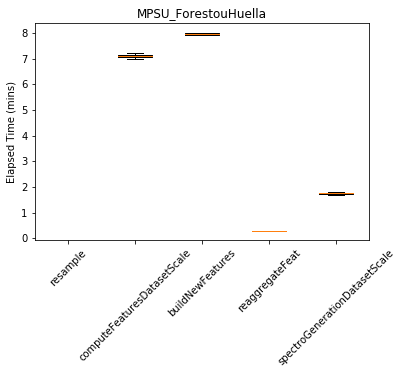

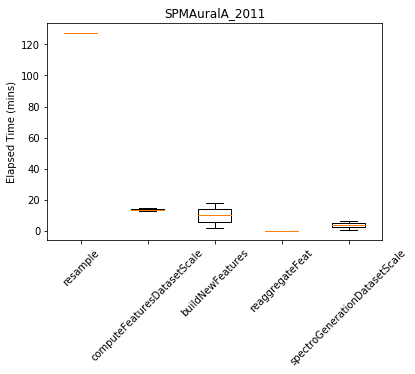

In [6]:
for ddd in np.unique(out['dataset_ID']):
#     ddd = np.unique(out['dataset_ID'])[1]

    list_block_anal = []
    for aa in anal_block: 
        list_block_anal.append(out[ (out['dataset_ID']==ddd) & (out['jobID_'+aa].notnull())]['usedWallTime'].values)

    fig, ax = plt.subplots()
    ax.boxplot(list_block_anal)
    plt.xticks(range(1,len(list_block_anal)+1), anal_block)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_ylabel('Elapsed Time (mins)')
    ax.set_title(ddd)


In [9]:
import sys
sys.exit()

SystemExit: 

/appli/conda-env/3.6/allohaEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3327: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
means_Scenario1=[]
std_Scenario1=[]
mins_Scenario1=[]
maxes_Scenario1=[]


for ddd in np.unique(out['dataset_ID']):
# ddd = np.unique(out['dataset_ID'])[1]

    list_block_anal = []
    for aa in anal_block: 
        list_block_anal.append(out[ (out['dataset_ID']==ddd) & (out['jobID_'+aa].notnull())]['usedWallTime'].values)

    x = compute_cumul_wt(list_block_anal,matind_scenar_1)
        
    # Scenario1 (the columns 1,2,-1 correspond to the block analysis in anal_block)
#     means_Scenario1.append(sum(np.mean(x,1)))
#     std_Scenario1.append(sum(np.std(x,1)))
#     maxes_Scenario1.append(sum(np.max(x,1)))
#     mins_Scenario1.append(sum(np.min(x,1)))  
    
    avTimeScenario1 = round(sum( compute_cumul_wt(list_block_anal,matind_scenar_1) ),1)
#     avTimeScenario2 = round(sum(np.mean( np.array(list_block_anal)[[0,1,2,-1],:] , 1)),1)
#     avTimeScenario3 = round(sum(np.mean( np.array(list_block_anal)[[1,2,3,4],:] , 1)),1)

    print('%%%%%%',ddd,'%%%%%%')
    print('LTAS & EPD :',avTimeScenario1,'(mins)')
    print('%%%%%%%%%%%% \n')

# fig, ax = plt.subplots()
# # create stacked errorbars:
# plt.errorbar(np.arange(len(means_Scenario1)), means_Scenario1, std_Scenario1, fmt='ok', lw=3)
# plt.errorbar(np.arange(len(means_Scenario1)), means_Scenario1, [np.array(means_Scenario1) - np.array(mins_Scenario1) , np.array(maxes_Scenario1) - np.array(means_Scenario1)],
#              fmt='.k', ecolor='gray', lw=10)
# plt.xlim(-1, len(means_Scenario1))
# plt.xticks(range(len(means_Scenario1)), np.unique(out['dataset_ID']))
# ax.tick_params(axis='x', labelrotation = 45)
# ax.set_ylabel('Elapsed Time (mins)')
# ax.set_title('LTAS & EPD')
